In [7]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [14]:
model = load_model('/home/ubuntu/data/iceberg/results/weights/VGG16_plus_simplev2_1train_08val.h5')

In [4]:
RESULTS_DIR = '/home/ubuntu/data/iceberg/results'

In [5]:
import bcolz
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="VGG16_conv_feats_with_aug/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels

trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("VGG16_conv_feats_with_aug/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("VGG16_conv_feats_with_aug/val_")

In [10]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/iceberg/pngs/valid',
        target_size=(224, 224),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 400 images belonging to 2 classes.


In [14]:
predictions = model.predict(val_conv_features)

In [36]:
# is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship.
#  therefore [1,0] is a ship and [0,1] is iceberg

[ 1.  0.] [ 0.63816  0.36184]
iceberg/valid_iceberg_106.png


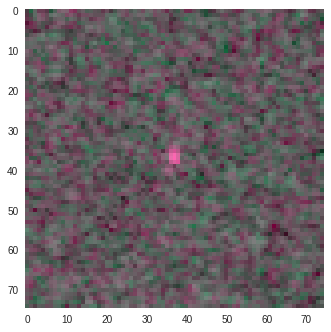

In [56]:
import imageio 
import matplotlib.pyplot as plt

img_num = 2
print(val_labels[img_num], predictions[img_num])
print(validation_generator.filenames[img_num])

base_dir = '/home/ubuntu/data/iceberg/pngs/valid/'
img = im = imageio.imread(base_dir + validation_generator.filenames[img_num])
plt.imshow(img)
plt.grid(False)
plt.show()


In [1]:
import numpy as np
import pandas as pd
import os

data_dir = '/home/ubuntu/data/iceberg'

def load_data(data_dir):
    train = pd.read_json(os.path.join(data_dir, 'train.json'))
    test = pd.read_json(os.path.join(data_dir, 'test.json'))
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)
print(train.shape, test.shape)

# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(img).astype(np.float32).reshape(75, 75) for img in df["band_1"]])
    X_band2 = np.array([np.array(img).astype(np.float32).reshape(75, 75) for img in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train_full = process_images(train)
X_test = process_images(test)

X_angle_train_full = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train_full = np.array(train["is_iceberg"])

(1604, 5) (8424, 4)


In [65]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train_full,
                                    X_angle_train_full, y_train_full, random_state=6, train_size=0.75, test_size=0.25)

X_train.shape, X_valid.shape, X_angle_train.shape, X_angle_valid.shape, y_train.shape, y_valid.shape

((1203, 75, 75, 3), (401, 75, 75, 3), (1203,), (401,), (1203,), (401,))

In [69]:
%matplotlib inline

def plot_img_set(img_num):
    # randomly needs the squeeze false parameter if you only want one row of images
    f,ax = plt.subplots(1,3,figsize=(20,10), squeeze=False)
    ax[0][0].imshow(X_valid[img_num, :, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(X_valid[img_num, :, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(X_valid[img_num, :, :,2]), ax[0][2].set_title("avg band1,2")
    

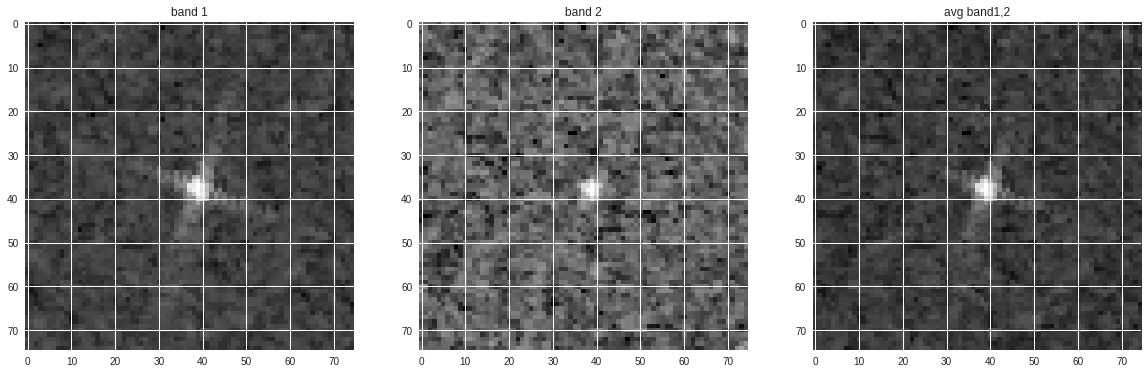

In [76]:
img_num = 
plot_img_set(img_num)

[ 1.  0.] [ 1.  0.]
iceberg/valid_iceberg_130.png


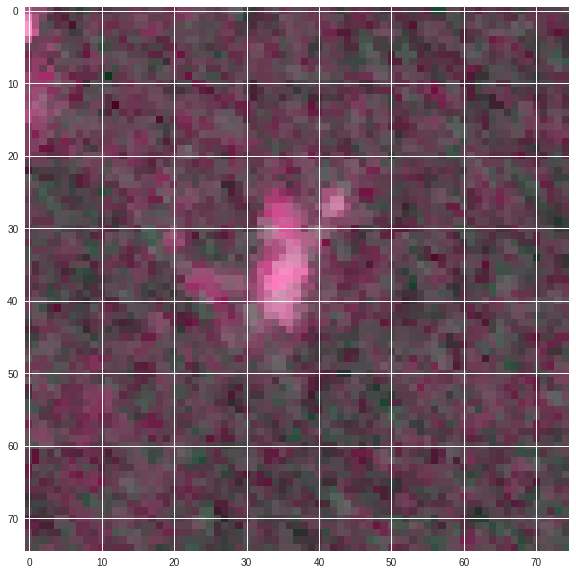

In [85]:
img_num = 8
print(val_labels[img_num], predictions[img_num])
print(validation_generator.filenames[img_num])

plt.figure(figsize=(20,10))
base_dir = '/home/ubuntu/data/iceberg/pngs/valid/'
img = imageio.imread(base_dir + validation_generator.filenames[img_num])
plt.imshow(img)
# plt.grid(False)
plt.show()

In [192]:
for i in range(len(validation_generator.filenames)):
    test = str(i) + ':' + str(predictions[i]) + ',' + str(val_labels[i]) + validation_generator.filenames[i] 
    print(test)

0:[ 0.99679  0.00321],[ 1.  0.]iceberg/valid_iceberg_0.png
1:[ 0.99626  0.00374],[ 1.  0.]iceberg/valid_iceberg_100.png
2:[ 0.63816  0.36184],[ 1.  0.]iceberg/valid_iceberg_106.png
3:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_108.png
4:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_109.png
5:[ 0.24387  0.75613],[ 1.  0.]iceberg/valid_iceberg_111.png
6:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_122.png
7:[ 0.00411  0.99589],[ 1.  0.]iceberg/valid_iceberg_123.png
8:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_130.png
9:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_131.png
10:[ 0.98365  0.01635],[ 1.  0.]iceberg/valid_iceberg_132.png
11:[ 0.27952  0.72048],[ 1.  0.]iceberg/valid_iceberg_133.png
12:[ 0.99973  0.00027],[ 1.  0.]iceberg/valid_iceberg_134.png
13:[ 0.99968  0.00032],[ 1.  0.]iceberg/valid_iceberg_135.png
14:[ 0.99682  0.00318],[ 1.  0.]iceberg/valid_iceberg_138.png
15:[ 0.99912  0.00088],[ 1.  0.]iceberg/valid_iceberg_139.png
16:[ 0.00006  0.99994],[ 1.  0.]iceberg/valid_iceberg_14.png
17:[ 0.  

In [219]:
def plot_img_set(img_num, img_num2, img_num3):
    
    f,ax = plt.subplots(3,3,figsize=(30,30), squeeze=False)
    # randomly needs the squeeze false parameter if you only want one row of images
    img = imageio.imread(base_dir + validation_generator.filenames[img_num])

    ax[0][0].imshow(img[:, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(img[:, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(img[:, :,2]), ax[0][2].set_title("avg band1,2")
    print(validation_generator.filenames[img_num])
    print(val_labels[img_num], predictions[img_num])
    print('max: ',img[:,:,0].max(), img[:,:,1].max(), img[:,:,2].max(),' | min: ',img[:,:,0].min(), img[:,:,1].min(), img[:,:,2].min(), ' | mean: ',img[:,:,0].mean(), img[:,:,1].mean(), img[:,:,2].mean())
 
    img2 = imageio.imread(base_dir + validation_generator.filenames[img_num2])
    ax[1][0].imshow(img2[:, :,0]), ax[1][0].set_title("band 1")
    ax[1][1].imshow(img2[:, :,1]), ax[1][1].set_title("band 2")
    ax[1][2].imshow(img2[:, :,2]), ax[1][2].set_title("avg band1,2")
    print(validation_generator.filenames[img_num2])
    print(val_labels[img_num2], predictions[img_num2])
    print('max: ',img2[:,:,0].max(), img2[:,:,1].max(), img2[:,:,2].max(),' | min: ',img2[:,:,0].min(), img2[:,:,1].min(), img2[:,:,2].min(), ' | mean: ',img2[:,:,0].mean(), img2[:,:,1].mean(), img2[:,:,2].mean())
                 
    img3 = imageio.imread(base_dir + validation_generator.filenames[img_num3])
    ax[2][0].imshow(img3[:, :,0]), ax[2][0].set_title("band 1")
    ax[2][1].imshow(img3[:, :,1]), ax[2][1].set_title("band 2")
    ax[2][2].imshow(img3[:, :,2]), ax[2][2].set_title("avg band1,2")
    print(validation_generator.filenames[img_num3])
    print(val_labels[img_num3], predictions[img_num3])
    print('max: ',img3[:,:,0].max(), img3[:,:,1].max(), img3[:,:,2].max(),' | min: ', img3[:,:,0].min(), img3[:,:,1].min(), img3[:,:,2].min(), ' | mean: ', img3[:,:,0].mean(), img3[:,:,1].mean(), img3[:,:,2].mean())
       

no_ice/valid_no_ice_326.png
[ 0.  1.] [ 0.8715  0.1285]
max:  254 186 220  | min:  45 0 60  | mean:  158.305066667 93.6432 125.976
no_ice/valid_no_ice_329.png
[ 0.  1.] [ 0.99432  0.00568]
max:  255 171 192  | min:  20 0 40  | mean:  121.040177778 103.303466667 112.139555556
no_ice/valid_no_ice_34.png
[ 0.  1.] [ 0.75256  0.24744]
max:  255 117 181  | min:  0 0 24  | mean:  72.0190222222 64.0264888889 68.0716444444


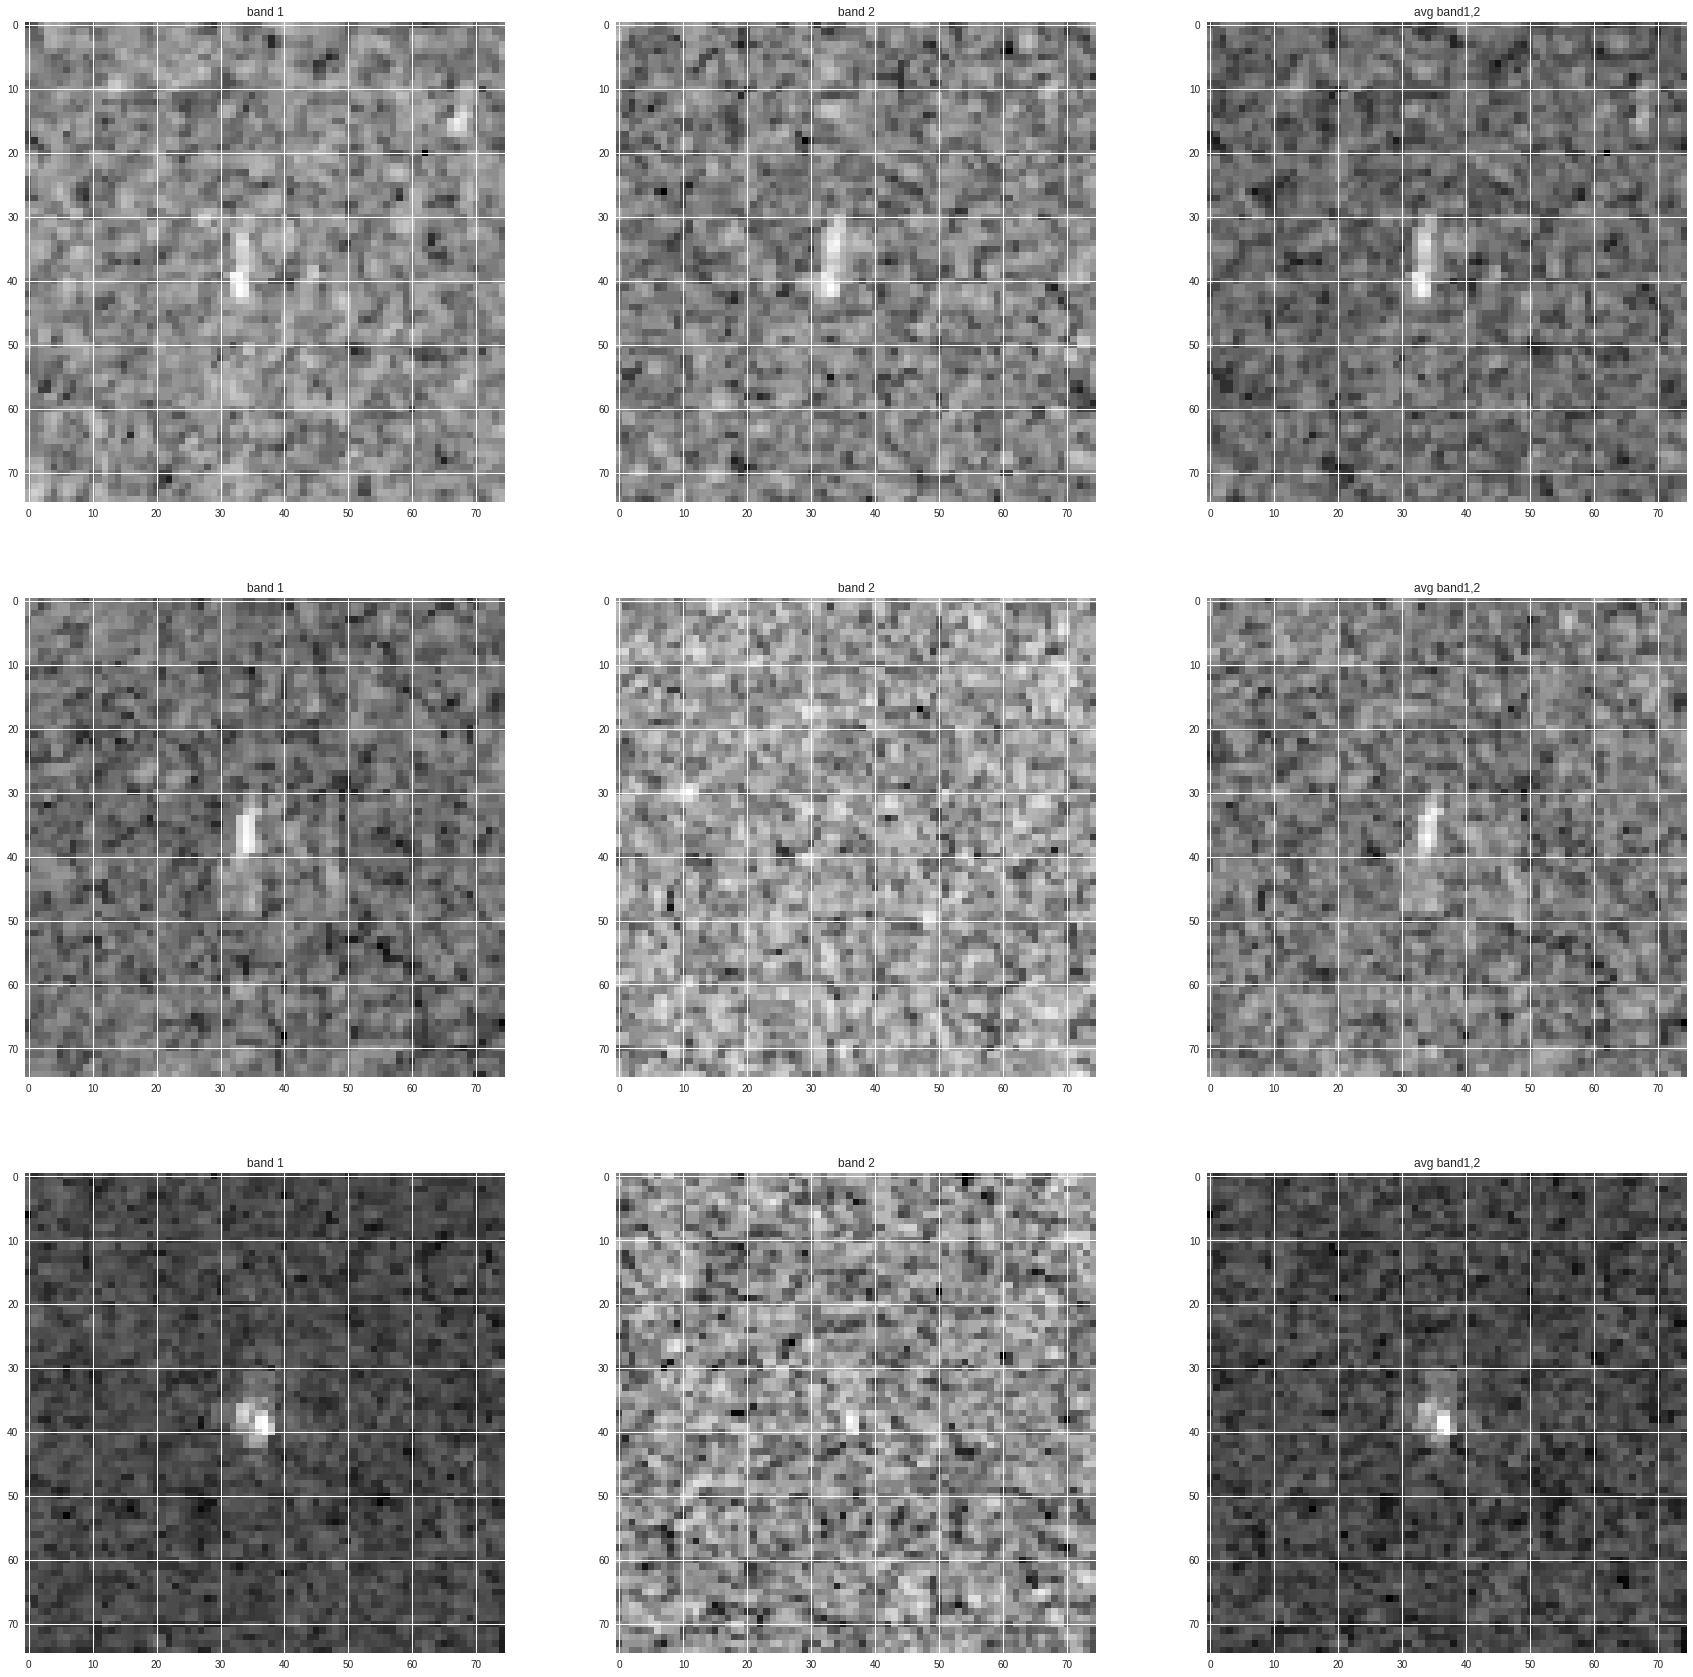

In [224]:
plot_img_set(322,323,326)

In [226]:
submit_nums = np.clip(predictions, 0.1, 0.9, out=predictions)

In [5]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

vgg_base = VGG16(weights='imagenet', include_top=False)

Using TensorFlow backend.


In [4]:
import imageio 

for i in range(len(X_test)):
#     rescaled_img = come back and do this to get rid of red error? 
    imageio.imwrite('/home/ubuntu/data/iceberg/pngs/test/test_' + str(i) + '.png', X_test[i])
    

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.36348342895508, 7.286025047302246]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.10124969482422, -10.549344062805176]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.59247589111328, 19.064424514770508]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.094146728515625, 1.6951769590377808]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.643619537353516, -1.7425440549850464]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.342647552490234, 2.375631093978882]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.560123443603516, 13.334912300109863]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.66743087768555, 1.5320980548858643]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.91899490356445, -8.767687797546387]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.95621871948242, -6.23074197769165]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.32843017578125, -2.8624119758605957]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-29.846954345703125, 20.251911163330078]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.154598236083984, -5.5762619972229]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.4871711730957, -2.5618789196014404]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.74079895019531, 3.9618029594421387]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.145545959472656, 7.610104084014893]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.29819869995117, 4.617335796356201]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.128334045410156, 22.54705047607422]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.24445343017578, 3.65413498878479]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.3044319152832, 11.064517974853516]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float3

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.95132064819336, 2.726417064666748]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.458370208740234, -5.6097259521484375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.97720718383789, 11.257747650146484]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.903804779052734, 10.51806926727295]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.285430908203125, -2.1043028831481934]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.05955123901367, 9.305703163146973]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.527793884277344, -5.457706928253174]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.66722106933594, -4.5675201416015625]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.98271560668945, 1.288741946220398]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.10681915283203, 10.78136920928955]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.46320343017578, -4.230053901672363]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.562744140625, 12.335858345031738]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float3

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.38737487792969, 5.162299156188965]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.36347961425781, -12.018630981445312]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.42648696899414, 0.267659991979599]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.101234436035156, 11.042247772216797]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.105712890625, -7.264803886413574]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.886173248291016, -7.583345890045166]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.434776306152344, 1.430385947227478]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.89059066772461, 8.618754386901855]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.51448440551758, -3.6641058921813965]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.9908332824707, -4.533980846405029]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.1002197265625, 10.543208122253418]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.387943267822266, 5.939894199371338]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.28325653076172, 10.512372016906738]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.388275146484375, 8.416337013244629]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.31290817260742, 1.817891001701355]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.497623443603516, 13.047992706298828]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.8956184387207, 0.23252399265766144]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.140838623046875, -0.7997480034828186]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.565277099609375, -2.2827110290527344]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.092777252197266, 2.461069107055664]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fro

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.91353225708008, 0.6651229858398438]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.095428466796875, -0.7863690257072449]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.15264892578125, 6.083528995513916]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.41584777832031, -5.6027679443359375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.6622314453125, 11.528648376464844]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-31.779539108276367, -8.103687286376953]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.74391174316406, -3.028856039047241]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.41946792602539, 11.777276992797852]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.653656005859375, 4.482728004455566]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.59437561035156, -8.67684555053711]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.4461784362793, -5.761712074279785]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.86452865600586, -6.293258190155029]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.26537322998047, -10.604415893554688]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.10559844970703, 2.4235129356384277]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.64480209350586, 3.0295779705047607]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.083988189697266, 9.268065452575684]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.14287185668945, 10.957218170166016]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.730552673339844, -12.283768653869629]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.22001647949219, 16.617496490478516]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.9661750793457, -2.5100998878479004]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.933834075927734, -2.187912940979004]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.43775177001953, -3.864651918411255]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.440765380859375, -7.07059907913208]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.95337677001953, 1.7236629724502563]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.28378677368164, 0.1118680015206337]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.555747985839844, -0.6993970274925232]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.404972076416016, 1.6387300491333008]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-40.01763153076172, -0.19490399956703186]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fr

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.57231521606445, 3.354104995727539]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.107460021972656, 21.292951583862305]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.452613830566406, -1.8001879453659058]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.32797622680664, -0.6313700079917908]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.92872619628906, -11.785087585449219]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.863624572753906, 1.2594720125198364]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.314571380615234, 2.9233319759368896]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.299591064453125, -7.853446006774902]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fro

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.576316833496094, -4.229292869567871]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.09222412109375, -4.441311836242676]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.626739501953125, 7.805877208709717]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.60274124145508, -1.3613200187683105]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.35576248168945, -1.037019968032837]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.61524963378906, 0.5138829946517944]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.34821701049805, -0.03315199911594391]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.771514892578125, -9.055564880371094]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.30398941040039, 2.8329238891601562]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.37858200073242, 5.997469902038574]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.499755859375, -9.522086143493652]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.490047454833984, -2.1081390380859375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.47709655761719, -3.8750360012054443]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.21221160888672, -1.457658052444458]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.544612884521484, 9.416339874267578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.613224029541016, -5.632894992828369]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.00741195678711, 11.078234672546387]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.38702392578125, 1.759063959121704]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.32224655151367, 5.325825214385986]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.41054153442383, -1.1703230142593384]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.34695053100586, 9.475208282470703]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.157493591308594, 14.033354759216309]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.917869567871094, 3.7975409030914307]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.65757751464844, -10.765905380249023]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.92921829223633, 13.642353057861328]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.607460021972656, 18.07781982421875]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.558231353759766, 15.05764389038086]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.36550521850586, -8.946975708007812]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.94895935058594, 6.60658597946167]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.908287048339844, -8.630684852600098]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.74256896972656, 12.848010063171387]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.73622512817383, -8.091839790344238]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-43.191471099853516, 4.203454971313477]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.49907684326172, -2.650412082672119]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.47349548339844, 1.5994670391082764]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.41912078857422, 22.895524978637695]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.87561798095703, -4.5536370277404785]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.68313980102539, 4.5770111083984375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.21669387817383, -2.8768210411071777]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.909976959228516, 2.248344898223877]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.28327941894531, -5.891142845153809]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.10389709472656, -6.40957498550415]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.547882080078125, -9.095237731933594]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.65011978149414, 20.643980026245117]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.53337478637695, -1.3985769748687744]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.216739654541016, -7.134357929229736]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-40.06757354736328, -10.819433212280273]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.69283676147461, -3.147562026977539]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.60894775390625, -8.474587440490723]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.41712951660156, 22.902753829956055]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.94164276123047, 21.403759002685547]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.99205780029297, 1.3241729736328125]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.0474967956543, 8.464749336242676]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.57304382324219, 13.576160430908203]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.562774658203125, -7.851109027862549]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.94139862060547, 10.90141773223877]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.58294677734375, -1.9101959466934204]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.59998321533203, -7.038239002227783]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.4643440246582, 9.438237190246582]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.508506774902344, 3.077315092086792]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.408634185791016, 5.543054103851318]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.94730758666992, -3.3850910663604736]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.15232849121094, -1.2915719747543335]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.7806396484375, 14.439905166625977]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.919883728027344, -1.0245219469070435]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.76213455200195, 8.653139114379883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.72574234008789, -7.809181213378906]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.309837341308594, -0.0028059999458491802]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.29872512817383, -9.02258586883545]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.304439544677734, -6.8995561599731445]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.72453308105469, 0.16694200038909912]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.43388748168945, -0.8148279786109924]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.849853515625, 14.281416893005371]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.110260009765625, 20.24169158935547]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.22312545776367, 11.950057983398438]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.1495361328125, -10.215825080871582]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.8327751159668, -5.825560092926025]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.73400115966797, -1.0204440355300903]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.952877044677734, 20.54009437561035]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.75493621826172, 0.6296859979629517]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.312286376953125, 6.372363090515137]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.367610931396484, -6.087385177612305]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.70144271850586, -5.135592937469482]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.3336296081543, 11.804203987121582]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.15542984008789, -11.21782398223877]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.47019577026367, 9.522574424743652]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.107444763183594, -11.585545539855957]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.067970275878906, -8.649548530578613]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.96641159057617, 5.51846981048584]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.8762092590332, 4.91249418258667]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.665340423583984, 3.0131239891052246]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.64994812011719, -9.79451847076416]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.202537536621094, -4.019298076629639]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.67403793334961, 3.864039897918701]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.757720947265625, 11.528648376464844]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.107181549072266, 8.677318572998047]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.364688873291016, -7.195775985717773]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.92505645751953, -6.755111217498779]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.29912185668945, -4.603882789611816]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.57883834838867, -7.45452880859375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.281585693359375, -7.330626964569092]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.135154724121094, -4.721128940582275]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.207611083984375, -1.242231011390686]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.1038932800293, 14.21745491027832]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.633445739746094, -5.146358966827393]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.09217071533203, 18.16084861755371]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.311248779296875, -3.582487106323242]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.1604118347168, 2.841876983642578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.57199478149414, -0.12365599721670151]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-31.497661590576172, 12.993535041809082]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.93778610229492, 10.555784225463867]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.19377136230469, 16.255887985229492]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.13972091674805, -7.229198932647705]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.227691650390625, 23.067707061767578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.146453857421875, 7.036671161651611]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.44002151489258, 4.081964015960693]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.21232604980469, -11.708632469177246]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.42131805419922, 14.871435165405273]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.94301223754883, -6.40957498550415]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.06826400756836, -8.27889347076416]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.009647369384766, 10.619779586791992]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.37644958496094, -5.830187797546387]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.08631134033203, 6.659708023071289]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.06549835205078, -2.4578890800476074]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.892093658447266, -7.705234050750732]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.14016342163086, -10.90584659576416]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.71483612060547, 10.845441818237305]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.17196273803711, 3.2185230255126953]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.667869567871094, -5.572597026824951]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.890506744384766, -6.001154899597168]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.45154571533203, -6.601202964782715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.61050033569336, -3.7215349674224854]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.86840057373047, 7.982820987701416]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.28827667236328, 12.743454933166504]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.61524963378906, 0.16612599790096283]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.58382034301758, 17.269878387451172]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.916908264160156, -6.373908042907715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.66229248046875, -9.378913879394531]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.68194580078125, -0.08136899769306183]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.40309524536133, -2.2278380393981934]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fro

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.585655212402344, -10.335936546325684]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.49057388305664, -0.5859320163726807]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.04338073730469, -13.885196685791016]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.05309295654297, -2.0913660526275635]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fr

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.514984130859375, -7.619073867797852]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.22682571411133, 1.6489629745483398]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.318275451660156, -0.28185200691223145]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.23110580444336, 22.826662063598633]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion fro

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.31989669799805, -0.5673570036888123]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.576385498046875, -3.55519700050354]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.65640640258789, -8.488917350769043]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.90252685546875, -6.720466136932373]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.0087776184082, 6.062967777252197]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.67959976196289, -10.746861457824707]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.478492736816406, -9.028420448303223]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.49241256713867, -0.6386680006980896]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.63417053222656, 4.617335796356201]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.738731384277344, 0.7327809929847717]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.943824768066406, -6.807814121246338]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.14303207397461, -2.374267101287842]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.979347229003906, -0.822763979434967]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.161399841308594, 1.8033519983291626]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-31.963844299316406, 8.469529151916504]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.470428466796875, 12.478455543518066]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.482398986816406, 1.7686009407043457]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.34707260131836, 9.956920623779297]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.61332702636719, -5.238292217254639]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.5146598815918, 6.835590839385986]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.562095642089844, -5.02249813079834]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.21242141723633, -4.486831188201904]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.88311004638672, 5.602799892425537]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.228668212890625, 0.74726402759552]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.160160064697266, -5.91176700592041]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-40.006004333496094, -9.419855117797852]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.12010192871094, -8.413043975830078]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.10468292236328, -0.1407109946012497]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.51332473754883, 3.262826919555664]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.807586669921875, 15.163171768188477]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.43408203125, -1.2198899984359741]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.59502029418945, -5.109807014465332]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.54066467285156, -0.28086400032043457]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.723793029785156, 4.093948841094971]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.26850128173828, 7.543125152587891]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.8254280090332, 9.66386604309082]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.52485275268555, -6.20789098739624]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.464500427246094, 3.612149953842163]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.7128791809082, -0.16881400346755981]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.52040481567383, 3.185853958129883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.31032180786133, 5.534328937530518]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.35580825805664, 10.783254623413086]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.532814025878906, -8.234109878540039]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.59416198730469, -10.394831657409668]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.27421569824219, -10.204387664794922]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.3509521484375, 14.380380630493164]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.926300048828125, 0.09439799934625626]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.719383239746094, 16.04912757873535]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.30158615112305, -0.5934060215950012]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.60041046142578, 1.0730630159378052]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.07204055786133, 0.9551830291748047]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.795841217041016, 13.652009010314941]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.79014587402344, 7.536354064941406]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.50459671020508, -12.268781661987305]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.54574203491211, -12.000785827636719]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.50088882446289, -9.042905807495117]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.43096923828125, 4.931046962738037]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.40126037597656, 0.163674995303154]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.514915466308594, -15.328932762145996]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.81053924560547, 5.375857830047607]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.24370574951172, -4.0351080894470215]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.605918884277344, 2.574618101119995]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.138893127441406, -5.329566955566406]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.13966369628906, -10.407480239868164]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.30353927612305, -5.101373195648193]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.0628776550293, 22.196155548095703]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.507293701171875, -4.910224914550781]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.43896484375, -1.6490529775619507]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.17853546142578, -5.479743003845215]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.02705383300781, 16.377296447753906]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.218963623046875, 1.2784099578857422]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.44321823120117, -8.236997604370117]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.590328216552734, -4.940889835357666]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.566280364990234, -8.767060279846191]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.42518615722656, 1.4749749898910522]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.575008392333984, 7.444025993347168]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.28224182128906, -6.433932781219482]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.940773010253906, -4.841886043548584]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.64176940917969, -6.51490592956543]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.90663146972656, -2.444957971572876]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.135772705078125, 12.203714370727539]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.12407302856445, -6.2406768798828125]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.26744842529297, -1.4132750034332275]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.34119415283203, -2.378462076187134]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.56546401977539, 0.7689210176467896]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.76544952392578, 4.063024997711182]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.168846130371094, -8.108613014221191]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.52963638305664, -2.6004741191864014]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.563018798828125, -2.458132028579712]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.05998229980469, 2.4975130558013916]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.14055633544922, -5.575882911682129]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.029361724853516, 3.970639944076538]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.055538177490234, 1.3717600107192993]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.21977615356445, -5.261343002319336]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.56494140625, 1.6544569730758667]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.74229049682617, 5.442051887512207]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.33004379272461, 6.199283123016357]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.48898696899414, -8.900524139404297]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-43.137813568115234, -5.1018290519714355]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.4879264831543, 0.09130699932575226]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.77477264404297, 12.550402641296387]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.405269622802734, -6.618605136871338]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.062347412109375, -5.280900001525879]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.459571838378906, -3.141587018966675]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.34004592895508, -5.185760974884033]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.12596130371094, -6.2406768798828125]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.56698989868164, 28.80270767211914]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.807735443115234, 19.212331771850586]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.43583679199219, -4.322332859039307]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.12339401245117, 11.133283615112305]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.902687072753906, 9.215216636657715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.22252655029297, 8.173458099365234]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.96445846557617, 5.212799072265625]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.74891662597656, 16.31249237060547]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.342567443847656, 2.1196789741516113]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.28465270996094, -2.06375789642334]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.40345001220703, 6.288133144378662]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-41.14849853515625, -0.3521620035171509]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.77886962890625, 1.7987580299377441]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.42529296875, 3.7623279094696045]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.18293380737305, 12.04409408569336]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.513389587402344, 22.952003479003906]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.92335510253906, -0.24806399643421173]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.36385726928711, 16.804794311523438]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from 

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.78080749511719, 7.73593282699585]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.82561111450195, 5.4828691482543945]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.69285583496094, -4.913424015045166]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.947628021240234, -0.4318470060825348]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.58158493041992, -14.19356918334961]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.858829498291016, 9.625232696533203]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.244327545166016, 3.581305980682373]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.4088134765625, 2.214608907699585]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.92876052856445, 0.40647101402282715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.44536590576172, -4.341114044189453]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.27616882324219, 11.952214241027832]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.092018127441406, -3.7232089042663574]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.15678787231445, 5.978516101837158]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.38853454589844, -3.7505850791931152]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.88447570800781, 7.681547164916992]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.45919418334961, 7.246400833129883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.590049743652344, -5.876777172088623]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.48847961425781, -6.568059921264648]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.38685989379883, 1.8611949682235718]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.21919631958008, 11.724544525146484]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.3516845703125, -7.846768856048584]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.52210998535156, -7.3735032081604]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.86891555786133, 7.336900234222412]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.31001281738281, -2.2830379009246826]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.521324157714844, 19.044002532958984]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.79417037963867, -3.647608995437622]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.3044319152832, 10.404218673706055]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.7816047668457, 14.761871337890625]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from flo

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.01508712768555, 9.675354957580566]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.59178161621094, -0.035964999347925186]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-35.148380279541016, 3.5883820056915283]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-31.724761962890625, 6.384566783905029]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.38075256347656, -9.649984359741211]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.222171783447266, 10.024017333984375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.72792434692383, -4.923587799072266]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.84508514404297, 13.401556968688965]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.67338562011719, 22.84244155883789]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.99473190307617, -2.8149759769439697]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.01010513305664, -1.1969980001449585]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.17240905761719, 19.625322341918945]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.19486618041992, 3.1379759311676025]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-43.05576705932617, 11.73884391784668]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.3919677734375, -4.55245304107666]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-45.59444808959961, -18.615808486938477]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from floa

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-38.130401611328125, -6.371987819671631]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.443519592285156, -0.7856169939041138]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-45.54275131225586, -1.122217059135437]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-32.32272720336914, 23.000606536865234]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.925621032714844, 7.365785121917725]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.62644577026367, 14.762138366699219]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.371604919433594, -6.645596027374268]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-37.53255081176758, -10.15990161895752]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.758148193359375, 15.190972328186035]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.067779541015625, 8.93241024017334]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.37874221801758, 12.375923156738281]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-34.97451400756836, -10.467159271240234]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from f

/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-33.87212371826172, 8.255769729614258]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-31.203922271728516, 9.579268455505371]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-39.52485275268555, -10.952228546142578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [-36.32719802856445, 15.791181564331055]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/usr/local/lib/python3.4/dist-packages/imageio/core/util.py:104: UserWarning: Conversion from fl

In [2]:
X_test.shape

(8424, 75, 75, 3)

In [10]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/iceberg/pngs/test',
        target_size=(224, 224),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 8424 images belonging to 1 classes.


In [11]:
conv_features = vgg_base.predict_generator(generator, (generator.n/generator.batch_size))

In [45]:
test_preds = model.predict(conv_features)

In [46]:
# above is wrong some how, need to figure this out for the prediction - end of day now

In [47]:
test_preds.shape

(8424, 2)

In [48]:
# the right column is the one I need to submit
from keras.utils import to_categorical
to_categorical(1)

array([ 0.,  1.])

In [52]:
test_preds

array([[  1.00000001e-01,   9.99964476e-01],
       [  7.16046929e-01,   2.83953071e-01],
       [  1.00000001e-01,   1.00000000e+00],
       ..., 
       [  1.00000001e-01,   1.00000000e+00],
       [  8.99999976e-01,   3.18334089e-04],
       [  8.99999976e-01,   4.02261429e-02]], dtype=float32)

In [54]:
submit_nums = np.clip(test_preds[:,1], 0.1, 0.9, out=test_preds[:,1])

In [55]:
submit_nums


array([ 0.89999998,  0.28395307,  0.89999998, ...,  0.89999998,
        0.1       ,  0.1       ], dtype=float32)

In [56]:
df = pd.DataFrame(submit_nums, columns=['is_iceberg'])

In [57]:
submit = pd.concat([test['id'], df], axis=1)

In [37]:
submit.shape

(8424, 2)

In [38]:
submit.to_csv('submit_vggpretrained_smallclip.csv', index=False)

In [39]:
import os

os.getcwd()

'/home/ubuntu/git/learningWithKaggle/ice'